In [59]:
import pandas as pd
import torch
from torch.utils.data import Dataset, DataLoader
import os
import matplotlib.pyplot as plt
from PIL import Image 
from torchvision.transforms import v2
import random
import torch.nn as nn
from torch.optim import AdamW
from torch.optim.lr_scheduler import StepLR
from tqdm import tqdm
import torchvision.models as models

In [60]:
df_info = pd.read_csv('number_pic_char.csv')

In [61]:
char_to_label = {}
label_to_char = {}

for character in df_info.loc[:19, 'name']:
    character = character.lower().replace(' ', '_')
    label = len(char_to_label.items())
    char_to_label[character] = label
    label_to_char[label] = character

In [62]:
with open('annotation.txt', 'r') as f:
    lines = f.readlines()

len(lines)

6752

In [5]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

In [6]:

class SimpsonsDataset(Dataset):
    
    def __init__(self, annotation_file, base_path, char_to_label, transform=None, augmentation=None, max_limit = 1000):
        self.base_path = base_path
        self.transform = transform
        self.augmentation = augmentation
        self.data = []
        self.max_limit = max_limit
        
        self.data_count = {}
        
        self.char_to_label = char_to_label
        
        with open(annotation_file) as f:
            lines = f.readlines()

        for line in lines:
            image_path, x1, y1, x2, y2, character = line.split(',')
            character = character.strip()
            
            character = self.char_to_label[character]
            
            if(not self.data_count.__contains__(character)):
                self.data_count[character] =1
                
            else:
                if(self.data_count[character] > self.max_limit):
                    continue
                
                if(self.data_count.__contains__(character)):
                    self.data_count[character] +=1
                
            full_path = os.path.join(base_path, image_path[2:].replace('/', '\\'))
            img = Image.open(full_path).convert('RGB')
            
            self.data.append({
                'image': img,
                'bbox': [float(x1), float(y1), float(x2), float(y2)],
                'character': character
            })
        
        if self.augmentation != None:
            self.augment_dataset()
        
        
    def __len__(self):
        return len(self.data)
    
    def __getitem__(self, idx):
        item = self.data[idx]
        img = item['image']
        bbox = item['bbox']
        
        if self.transform:
            img = self.transform(img)
        
        item['character'] = torch.tensor(item['character'])
        
        return img.to(device), torch.tensor(bbox).to(device), item['character'].to(device)

    def augment_dataset(self):
        augmented_data = []
        
        for item in self.data:
            
            while (self.data_count[item['character']] < self.max_limit):
                aug_img, aug_bbox = self.apply_augmentations(item['image'], item['bbox'])
                augmented_data.append({
                    'image': aug_img,
                    'bbox': aug_bbox,
                    'character': item['character']
                })
                
                self.data_count[item['character']] += 1
                
        self.data.extend(augmented_data)


    def apply_augmentations(self, img, bbox):
        bbox = list(bbox)
        
        if random.random() > 0.5:
            img = v2.functional.hflip(img)
            bbox[0], bbox[2] = 1 - bbox[2], 1 - bbox[0]
        
        img = self.augmentation(img)
        return img, bbox
    
    def get_count(self):
        return self.data_count

In [7]:
augmentation = v2.Compose([
            v2.ColorJitter(brightness=0.2, contrast=0.2, saturation=0.2, hue=0.1),
            v2.RandomRotation(degrees=15),
            v2.RandomResizedCrop(size=(224, 224), scale=(0.8, 1.0), ratio=(0.75, 1.33))
        ])

transform = v2.Compose([
    v2.Resize((128, 128)),
    v2.ToTensor(),
    v2.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
])

        
base_path = ''
annotation_file = 'annotation.txt'

train_dataset = SimpsonsDataset(annotation_file, base_path, char_to_label, transform=transform, augmentation=augmentation)

c:\Python311\Lib\site-packages\torchvision\transforms\v2\_deprecated.py:42: UserWarning: The transform `ToTensor()` is deprecated and will be removed in a future release. Instead, please use `v2.Compose([v2.ToImage(), v2.ToDtype(torch.float32, scale=True)])`.Output is equivalent up to float precision.
  warnings.warn(


In [8]:
num_classes = len(train_dataset.get_count())

len(train_dataset), len(train_dataset.get_count())

(18000, 18)

In [9]:
batch_size = 256

train_dataloader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)

In [81]:
class SimpsonModel(nn.Module):
    
    def __init__(self, num_classes=18):
        super().__init__()
        self.num_classes = num_classes
        
        self.resnet = models.resnet18(weights=models.ResNet18_Weights)
        self.resnet = self.resnet.to(device)
        for p in self.resnet.parameters():
            p.requires_grad = False
            
        for param in self.resnet.layer4.parameters():
            param.requires_grad = True
            
        self.resnet = nn.Sequential(*list(self.resnet.children())[:-2])
        
        self.classification_head = nn.Sequential(
            nn.Conv2d(512, 256, kernel_size=3, padding=1),
            nn.ReLU(),
            nn.Conv2d(256, 128, kernel_size=3, padding=1),
            nn.ReLU(),
            nn.AdaptiveAvgPool2d((1, 1)),
            nn.Flatten(),
            nn.Linear(128, 128),
            nn.GELU(),
            nn.BatchNorm1d(128),
            nn.Linear(128, num_classes),
        )
        
    def forward(self, x):
        features = self.resnet(x)
        
        class_logits = self.classification_head(features)
        
        return class_logits

In [82]:
model = SimpsonModel(num_classes).to(device)

ud    = []
lossi = []

In [83]:
lr = 1e-3
epochs = 9

In [92]:
loss_fn = nn.CrossEntropyLoss()
optimizer = AdamW(model.parameters(), lr=0.000729, weight_decay=1e-2)
scheduler = StepLR(optimizer, step_size=3, gamma=0.9)

for epoch in range(epochs):
    model.train()
    epoch_loss = 0.0
    
    for i, (img, bbox, char) in enumerate(train_dataloader):

        output = model(img)
        char = char.to(device)

        optimizer.zero_grad()
        loss = loss_fn(output, char)

        loss.backward()
        optimizer.step()
        epoch_loss += loss.item()

        with torch.no_grad():
            lossi.append(loss.log10().item())
            ud.append([
                            ((optimizer.param_groups[0]['lr'] * p.grad).std() / p.data.std()).log10().item()
                            if p.grad is not None else None
                            for p in model.parameters()
                        ])    
    avg_loss = epoch_loss / len(train_dataloader)
    scheduler.step()
    current_lr = optimizer.param_groups[0]['lr']
    print(f"Epoch {epoch+1} completed. Current Learning Rate: {current_lr}. Average Loss: {avg_loss:.10f}")

C:\Users\ASUS\AppData\Local\Temp\ipykernel_15860\2321207472.py:57: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  item['character'] = torch.tensor(item['character'])


Epoch 1 completed. Current Learning Rate: 0.000729. Average Loss: 0.0093414308
Epoch 2 completed. Current Learning Rate: 0.000729. Average Loss: 0.0133260801
Epoch 3 completed. Current Learning Rate: 0.0006561000000000001. Average Loss: 0.0093209828
Epoch 4 completed. Current Learning Rate: 0.0006561000000000001. Average Loss: 0.0066278742
Epoch 5 completed. Current Learning Rate: 0.0006561000000000001. Average Loss: 0.0031410406
Epoch 6 completed. Current Learning Rate: 0.00059049. Average Loss: 0.0046903063
Epoch 7 completed. Current Learning Rate: 0.00059049. Average Loss: 0.0014831810
Epoch 8 completed. Current Learning Rate: 0.00059049. Average Loss: 0.0010225361
Epoch 9 completed. Current Learning Rate: 0.000531441. Average Loss: 0.0019516394


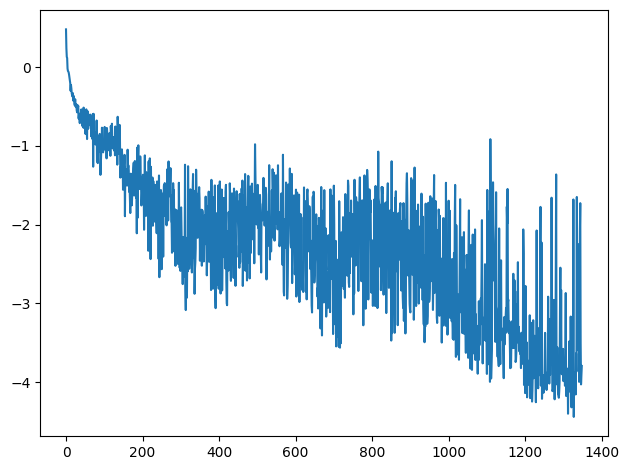

In [93]:
plt.plot(lossi)

plt.tight_layout()

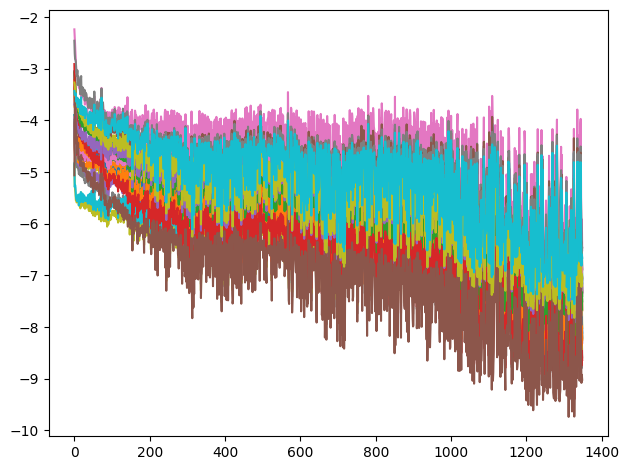

In [94]:
plt.plot(ud)

plt.tight_layout()

In [95]:
class SimpsonsTestDataset(Dataset):
    
    def __init__(self, base_path, transform):
        super().__init__()
        self.dataset = []
        self.transform = transform
        
        self.class_names = []
        
        image_names = os.listdir(base_path)
        
        for name in image_names:
            full_path = os.path.join(base_path, name)
            image = Image.open(full_path).convert('RGB')
            
            name = self.clean_image_name(name)
            
            if(name=='mayor_quimby' or name == 'lenny_leonard'):
                continue
            
            self.class_names.append(name)
            
            self.dataset.append({
                'img' : image,
                'name': name
            })
    
    def __getitem__(self, idx):
        item = self.dataset[idx]
        img = item['img']
        img = self.transform(img)
    
        char = item['name']
        return img.to(device), char_to_label[char]
    
    def __len__(self):
        return len(self.dataset)
    
    def get_class_names(self):
        return set(self.class_names)
    
    def clean_image_name(self, name):
        parts = name.split('_')
        base_name = '_'.join(parts[:-1])  
        return base_name

In [96]:
test_base_path = 'kaggle_simpson_testset\kaggle_simpson_testset'


test_dataset = SimpsonsTestDataset(test_base_path, transform)

In [97]:
test_dataloader = DataLoader(test_dataset, batch_size=batch_size, shuffle=True)

In [98]:
def evaluate(dataloader):
    model.eval()
    correct = 0
    amount = 0
    for (img, chars) in dataloader:
        logits = model(img)
        
        pred = torch.argmax(logits, dim=1)
        
        chars = list(chars.detach().numpy())
        
        count = (pred.cpu().detach().numpy() == chars).sum()
        
        correct += count
        amount  += len(chars)
        
    return (correct / amount)

acc = evaluate(test_dataloader)

print(f'Test Accuracy = {acc:.4f}')

Test Accuracy = 0.9427


In [99]:
# Save the model

# torch.save(model.state_dict(), 'tranformer_simpsonsModel.pth')